# Clustering at state level

## imports

In [45]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.preprocessing import PowerTransformer
from utils import add_Loss, clean_data_state

from pyclustering.utils.metric import distance_metric, type_metric
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer,random_center_initializer

## Import and clean data

In [25]:
#Select the dataset of one season of one year
YEAR = 2019
SEASON = "Kharif" # or "Kharif" 

#Path to the dataset
pathData = f"Data\RawDataUnified\RawData_{YEAR}_{SEASON}"
print(pathData)


df = pd.read_csv(pathData)

#Clean an add loss to data
df=add_Loss(clean_data_state(df))
df

Data\RawDataUnified\RawData_2019_Kharif


C:\Users\marti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,State,Crop,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Sum Insured (Inr),Indemnity Level,2002 Yield,2003 Yield,2004 Yield,2005 Yield,2006 Yield,2007 Yield,2008 Yield,2009 Yield,2010 Yield,2011 Yield,2012 Yield,2013 Yield,2014 Yield,2015 Yield,2016 Yield,2017 Yield,Loss
key,,,,,,,,,,,,,,,,,,,,,,,,
andhra pradesh_anantapur_agali__agali,0,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,1271.228148,463.99375,343.818182,264.534667,150.820333,87.096222,108.775,70.00,295.00,89.00,99.000000,2888.776861,14230.814316
andhra pradesh_anantapur_agali__akkagaladevarahalli,0,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,1271.228148,463.99375,343.818182,264.534667,150.820333,87.096222,108.775,58.00,232.00,120.00,99.000000,2888.776861,14464.016467
andhra pradesh_anantapur_agali__hulikeradevarahalli,0,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,1271.228148,463.99375,343.818182,264.534667,150.820333,87.096222,108.775,67.00,295.00,89.00,99.000000,2888.776861,14230.814316
andhra pradesh_anantapur_agali__inagalore,0,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,1271.228148,463.99375,343.818182,264.534667,150.820333,87.096222,108.775,62.00,232.00,120.00,99.000000,2888.776861,14464.016467
andhra pradesh_anantapur_agali__kodihalli,0,Arhar,216.609811,0.168514,28750.0,4844.772967,0.8,1096.14211,1343.496017,1231.68725,1372.571508,1271.228148,463.99375,343.818182,264.534667,150.820333,87.096222,108.775,70.00,295.00,89.00,99.000000,2888.776861,14230.814316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
west bengal_uttar dinajpur__hemtabad__,13,Aus Paddy,216.609811,1.857143,60500.0,112357.142857,0.9,1096.14211,1343.496017,1231.68725,1591.450000,1223.840000,1533.26000,1657.400000,1479.010000,1814.600000,1748.970000,1781.370,1942.86,2086.49,2346.79,2880.261241,2049.119790,5086.938832
west bengal_uttar dinajpur__itahar__,13,Aus Paddy,216.609811,1.857143,60500.0,112357.142857,0.9,1096.14211,1343.496017,1231.68725,1591.450000,1223.840000,1533.26000,1657.400000,1479.010000,1814.600000,1748.970000,1781.370,1942.86,2086.49,2346.79,2880.261241,2049.119790,5086.938832
west bengal_uttar dinajpur__kaliaganj__,13,Aus Paddy,216.609811,1.857143,60500.0,112357.142857,0.9,1096.14211,1343.496017,1231.68725,1591.450000,924.460000,1841.07000,2069.640000,1053.080000,1641.160000,1406.630000,1781.370,1942.86,2086.49,2346.79,2880.261241,2049.119790,5086.938832


## Preprocessing et fonctions utiles K-Means

In [4]:
data = pd.get_dummies( df, columns=["Crop"])

for c in data.columns:
    if c != "State":
        pt = PowerTransformer()
        data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

data_list =data.to_numpy()

In [10]:
def tab_cluster(clusters,donnees):
    tab_clusters = np.zeros(len(donnees)) #tab_clusters[i] renvoit le numéro de cluster de la i-ème ligne
    for i in range(k):
        for x in clusters[i]:
            tab_clusters[x] = i
    return tab_clusters

list_state = pd.unique(pd.read_csv(pathData)["State"])

def get_liste_state_cluster(clusters,donnees):
    df2 = donnees.copy(deep = True)
    df2["Cluster"] = tab_cluster(clusters,donnees)
    liste_state_cluster = []
    for i in range(len(list_state)):
        l = []
        l.append(list_state[i])
        l.append(np.bincount(df2[df2["State"] == i]["Cluster"].to_numpy().astype(int)).argmax())
        liste_state_cluster.append(l)
    return liste_state_cluster

C:\Users\marti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## K-Means avec distance perso

In [6]:
# Définition d'une distance entre deux parcelles avec forte pénalisation si état différent

def distance_state_penalized(point1, point2):
    if point1[0] == point2[0]:
        result = 0.0
    else:
        result = 9*10**15
    p1_numpy = np.array(point1[1:])
    p2_numpy = np.array(point2[1:])
    result += np.linalg.norm(p1_numpy-p2_numpy)
    return result

metric_perso = distance_metric(type_metric.USER_DEFINED, func=distance_state_penalized)

In [7]:
# Nombre de clusters
k = 7

# Prepare initial centers using K-Means++ method.
initial_centers = kmeans_plusplus_initializer(data_list, k).initialize()
 
# Create instance of K-Means algorithm with prepared centers.
kmeans_instance = kmeans(data_list, initial_centers,metric = metric_perso)
 
# Run cluster analysis and obtain results.
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()

In [8]:
liste_state_cluster = get_liste_state_cluster(clusters,df)
liste_state_cluster

[['Andhra Pradesh', 1],
 ['Chhattisgarh', 0],
 ['Gujarat', 0],
 ['Haryana', 0],
 ['Jharkhand', 0],
 ['Karnataka', 3],
 ['Madhya Pradesh', 0],
 ['Maharashtra', 0],
 ['Odisha', 1],
 ['Rajasthan', 0],
 ['Telangana', 6],
 ['Uttar Pradesh', 0],
 ['Uttarakhand', 1],
 ['West Bengal', 2]]

## K-Means avec définition d'une distance entre états

In [64]:
# regroupement des données par états
liste_df = []
for col in data.columns:
    if col != "State":
        df_by_state_prov = data.groupby("State")
        df_by_state_prov = df_by_state_prov[col].apply(np.array).to_frame()
        liste_df.append(df_by_state_prov[col])

df_by_state = pd.concat(liste_df,axis=1)
df_by_state


,Area Sown (Ha),Area Insured (Ha),SI Per Ha (Inr/Ha),Sum Insured (Inr),Indemnity Level,2002 Yield,2003 Yield,2004 Yield,2005 Yield,2006 Yield,...,Crop_Sunflower IRR,Crop_Sunflower Un-IRR,Crop_Taramira,Crop_Til (Sesame),Crop_Tomato,Crop_Urad,Crop_Urad Un-IRR,Crop_Wheat,Crop_Wheat IRR,Crop_Wheat Un-IRR
State,,,,,,,,,,,,,,,,,,,,,
0,"[0.20916218398224784, 0.20916218398224784, 0.2...","[1.0037981936405962, 1.0037981936405962, 1.003...","[-0.8085527423744752, -0.8085527423744752, -0....","[0.1392766536099348, 0.1392766536099348, 0.139...","[-0.3198520349067133, -0.3198520349067133, -0....","[0.04469661544710228, 0.04469661544710228, 0.0...","[0.5127516709866342, 0.5127516709866342, 0.512...","[0.5446061435624959, 0.5446061435624959, 0.544...","[0.6335774660125708, 0.6335774660125708, 0.633...","[-1.9721020411963335, -1.9721020411963335, -1....",...,"[-0.03317245525030668, -0.03317245525030668, -...","[-0.03383201008439359, -0.03383201008439359, -...","[-0.03891125452610982, -0.03891125452610982, -...","[-0.027099635919418653, -0.027099635919418653,...","[-0.009391268334929882, -0.009391268334929882,...","[-0.03903284747662696, -0.03903284747662696, -...","[-0.006398919559813339, -0.006398919559813339,...","[-0.4960667663993583, -0.4960667663993583, -0....","[-0.25729600938596, -0.25729600938596, -0.2572...","[-0.10462685378575722, -0.10462685378575722, -..."
1,"[0.20916218398224784, 0.20916218398224784, 0.2...","[1.749281624952688, 1.749281624952688, 1.74928...","[-2.6891035672027668, -2.6891035672027668, -2....","[0.10019879215620414, 0.10019879215620414, 0.1...","[-0.3198520349067133, -0.3198520349067133, -0....","[0.04469661544710228, 0.04469661544710228, 0.0...","[0.5127516709866342, 0.5127516709866342, 0.512...","[0.5446061435624959, 0.5446061435624959, 0.544...","[0.6335774660125708, 0.6335774660125708, 0.633...","[0.6465804074530026, 0.6465804074530026, 0.646...",...,"[-0.03317245525030668, -0.03317245525030668, -...","[-0.03383201008439359, -0.03383201008439359, -...","[-0.03891125452610982, -0.03891125452610982, -...","[-0.027099635919418653, -0.027099635919418653,...","[-0.009391268334929882, -0.009391268334929882,...","[-0.03903284747662696, -0.03903284747662696, -...","[-0.006398919559813339, -0.006398919559813339,...","[-0.4960667663993583, -0.4960667663993583, -0....","[-0.25729600938596, -0.25729600938596, -0.2572...","[-0.10462685378575722, -0.10462685378575722, -..."
2,"[7.050761498846274, 7.050761498846274, 7.05076...","[1.915209111952602, 1.915209111952602, 1.91520...","[-0.8085527423744752, -0.8085527423744752, -0....","[3.6354085167257915, 3.6354085167257915, 3.635...","[-0.3198520349067133, -0.3198520349067133, -0....","[0.04469661544710228, 0.04469661544710228, 0.0...","[0.5127516709866342, 0.5127516709866342, 0.512...","[0.5446061435624959, 0.5446061435624959, 0.544...","[0.6335774660125708, 0.6335774660125708, 0.633...","[-0.27025706315655096, -0.23473732115032503, -...",...,"[-0.03317245525030668, -0.03317245525030668, -...","[-0.03383201008439359, -0.03383201008439359, -...","[-0.03891125452610982, -0.03891125452610982, -...","[-0.027099635919418653, -0.027099635919418653,...","[-0.009391268334929882, -0.009391268334929882,...","[-0.03903284747662696, -0.03903284747662696, -...","[-0.006398919559813339, -0.006398919559813339,...","[-0.4960667663993583, -0.4960667663993583, -0....","[-0.25729600938596, -0.25729600938596, -0.2572...","[-0.10462685378575722, -0.10462685378575722, -..."
3,"[0.20916218398224784, 0.20916218398224784, 0.2...","[-0.6705790084849246, -0.6705790084849246, -0....","[-0.1877826320820115, -0.1877826320820115, -0....","[-2.47638670683907, -2.47638670683907, -2.4763...","[1.5912586968619373, 1.5912586968619373, 1.591...","[0.04469661544710228, 0.04469661544710228, 0.0...","[0.5127516709866342, 0.5127516709866342, 0.512...","[0.5446061435624959, 0.5446061435624959, 0.544...","[0.6335774660125708, 0.6335774660125708, 0.633...","[0.6465804074530026, 0.6465804074530026, 0.646...",...,"[-0.03

In [68]:
# Nombre de clusters
k = 3

# Prepare initial centers using K-Means++ method.
initial_centers = random_center_initializer(df_by_state, k).initialize()
 
# Create instance of K-Means algorithm with prepared centers.
kmeans_instance = kmeans(df_by_state, initial_centers)
 
# Run cluster analysis and obtain results.
kmeans_instance.process()
clusters = kmeans_instance.get_clusters()
final_centers = kmeans_instance.get_centers()

KeyError: 8

In [ ]:
# Distance entre états



## DBSCAN

In [47]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(metric=metric_perso).fit(pd.get_dummies( df, columns=["Crop"]).to_numpy())

KeyboardInterrupt: 

In [46]:
len(np.unique(clustering.labels_))

8001

##  K Prototypes

In [3]:
from kmodes.kprototypes import KPrototypes

In [4]:
def get_liste_state_cluster_2(clusters,donnees):
    df2 = donnees.copy(deep = True)
    df2["Cluster"] = clusters
    liste_state_cluster = []
    for i in range(len(list_state)):
        l = []
        l.append(list_state[i])
        l.append(np.bincount(df2[df2["State"] == i]["Cluster"].to_numpy().astype(int)).argmax())
        liste_state_cluster.append(l)
    return liste_state_cluster

In [5]:
list_state = pd.unique(pd.read_csv(pathData)["State"])

C:\Users\marti\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
kprot_data = df.copy()
#Pre-processing
for c in df.columns[2:]:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

categorical_columns = [0, 1] 

In [8]:
def categorical_dissimilarity(a, b, **_):
    """Dissimilarity function with state penalization"""
    return np.sum(a[0] != b[0])*9*10**15 + np.sum(a[1] != b[1])

In [12]:
#Actual clustering
n_clusters = 4
kproto = KPrototypes(n_clusters= n_clusters, init='Cao', n_jobs = 4,cat_dissim=categorical_dissimilarity)
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

In [26]:
list_state_cluster = get_liste_state_cluster_2(clusters,df)
list_state_cluster

[['Andhra Pradesh', 3],
 ['Chhattisgarh', 1],
 ['Gujarat', 1],
 ['Haryana', 1],
 ['Jharkhand', 1],
 ['Karnataka', 0],
 ['Madhya Pradesh', 1],
 ['Maharashtra', 0],
 ['Odisha', 2],
 ['Rajasthan', 0],
 ['Telangana', 3],
 ['Uttar Pradesh', 0],
 ['Uttarakhand', 1],
 ['West Bengal', 3]]

In [11]:
SEASON

'Kharif'

## Interprétation clusters

In [37]:
clusters_state =[3,3,3,3,1,3,1,2,3,2,3,1,3,3]
list_state

array(['Andhra Pradesh', 'Chhattisgarh', 'Gujarat', 'Haryana',
       'Jharkhand', 'Karnataka', 'Madhya Pradesh', 'Maharashtra',
       'Odisha', 'Rajasthan', 'Telangana', 'Uttar Pradesh', 'Uttarakhand',
       'West Bengal'], dtype=object)

In [39]:
liste_crop = pd.unique(df["Crop"])
liste_crop

array(['Arhar', 'Paddy', 'Bajra', 'Castor', 'Chilli IRR', 'Chilli Un-IRR',
       'Cotton IRR', 'Cotton Un-IRR', 'Groundnut', 'Groundnut IRR',
       'Groundnut Un-IRR', 'Jowar', 'Maize', 'Moong', 'Navane',
       'Sugarcane Plant', 'Sugarcane Ratoon', 'Sunflower', 'Urad',
       'Onion', 'Turmeric', 'Paddy Un-IRR', 'Paddy IRR', 'Soybean',
       'Ragi', 'Til (Sesame)', 'Moth', 'Banana', 'Cotton', 'Arhar IRR',
       'Arhar Un-IRR', 'Bajra IRR', 'Bajra Un-IRR', 'Cabbage', 'Cowpea',
       'Moong Un-IRR', 'Moth Un-IRR', 'Jowar IRR', 'Jowar Un-IRR',
       'Maize IRR', 'Maize Un-IRR', 'ONION IRR', 'Onion Un-IRR',
       'Potato Un-IRR', 'Potato IRR', 'Ragi Un-IRR', 'Ragi IRR',
       'Save Un-IRR', 'Soybean Un-IRR', 'Soybean IRR', 'Sunflower Un-IRR',
       'Sunflower IRR', 'Til (Sesame) Un-IRR', 'Tomato', 'Urad Un-IRR',
       'KODO-KUTKI', 'Lentil (Masoor)', 'Niger Seed', 'Ginger',
       'Guar Seed', 'Rice', 'TURMERIC', 'Aman paddy', 'Aus Paddy', 'Jute'],
      dtype=object)

In [42]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_copy = df.copy(deep=True)
df_copy["Crop"] = le.fit_transform(df_copy["Crop"])
crop_majoritaire = []
for i in range(len(list_state)):
    crop_majoritaire.append(liste_crop[np.bincount(df_copy[df_copy["State"]==i]["Crop"]).argmax()])
crop_majoritaire

['Maize Un-IRR',
 'Onion Un-IRR',
 'Navane',
 'Chilli Un-IRR',
 'Maize Un-IRR',
 'Arhar Un-IRR',
 'Sunflower Un-IRR',
 'Sunflower Un-IRR',
 'Maize Un-IRR',
 'Chilli Un-IRR',
 'Soybean Un-IRR',
 'Maize Un-IRR',
 'Maize Un-IRR',
 'Arhar']

In [44]:
crop_cluster =pd.DataFrame([ [clusters_state[i],crop_majoritaire[i]] for i in range(len(clusters_state))],columns = ["Cluster","Crop"])
crop_cluster

,Cluster,Crop
0,3,Maize Un-IRR
1,3,Onion Un-IRR
2,3,Navane
3,3,Chilli Un-IRR
4,1,Maize Un-IRR
5,3,Arhar Un-IRR
6,1,Sunflower Un-IRR
7,2,Sunflower Un-IRR
8,3,Maize Un-IRR
9,2,Chilli Un-IRR


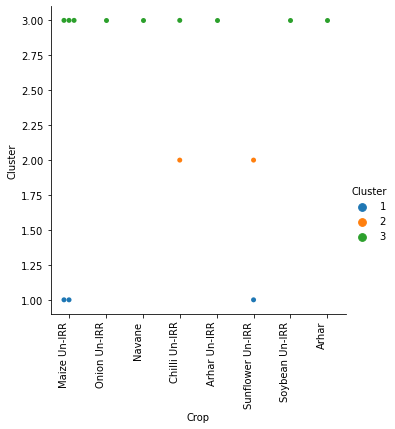

In [46]:
sn.catplot(x='Crop', y='Cluster', kind="swarm", hue='Cluster', data=crop_cluster) #sample is use to shuffle the rows of the dataset
plt.xticks(rotation=90, ha='right')
plt.show()